# 1. Importing Libraries


In [883]:
import pandas as pd
from sklearn.model_selection import train_test_split
import catboost as CatBoost
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import numpy as np
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
import xgboost as xgb

# 2. Loading and Exploring the Data

In [884]:
df = pd.read_csv('data/cirrhosis.csv')

In [885]:
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [886]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

In [887]:
df['Status'].value_counts()

Status
C     232
D     161
CL     25
Name: count, dtype: int64

# 3. Data Cleaning and Preparation

In [888]:
df.drop(columns='ID', inplace=True)

In [889]:
df['Age'] = round(df['Age']/365.0,2)
df.loc[df['Status']=='CL','Status'] = 'C'

# 4. Scaling or Normalizing Data


## `OrdinalEncoder` | `LabelEncoder`

In [890]:
status_enc = OrdinalEncoder(categories= [['C','D']])
df['Status'] = status_enc.fit_transform(df['Status'].values.reshape(-1,1))

lbl_enc = LabelEncoder()
df['Sex'] = lbl_enc.fit_transform(df['Sex'].values)

drug_enc = OrdinalEncoder(categories= [['Placebo','D-penicillamine']], handle_unknown='use_encoded_value', unknown_value=np.nan)
df['Drug'] = drug_enc.fit_transform(df['Drug'].values.reshape(-1,1))

edema_enc = OrdinalEncoder(categories= [['N','S','Y']], handle_unknown='use_encoded_value', unknown_value=np.nan)
df['Edema'] = edema_enc.fit_transform(df['Edema'].values.reshape(-1,1))

yn_enc = OrdinalEncoder(categories= [['N','Y']], handle_unknown='use_encoded_value', unknown_value=np.nan)
df['Ascites'] = yn_enc.fit_transform(df['Ascites'].values.reshape(-1,1))
df['Hepatomegaly'] = yn_enc.fit_transform(df['Hepatomegaly'].values.reshape(-1,1))
df['Spiders'] = yn_enc.fit_transform(df['Spiders'].values.reshape(-1,1))

## `IterativeImputer`

In [891]:
itr_imp = IterativeImputer()
temp = itr_imp.fit_transform(df)
df = pd.DataFrame(temp, columns=df.columns)

# 5. Model Building and Training


In [892]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='Status'),df['Status'], test_size=0.3)

## Functions

### `Importance Features`

In [893]:
def plot_importance_features(model):
    feature_less_importance = [feature  for feature, importance in dict(zip(model.feature_names_in_, model.feature_importances_)).items() if importance < 0.1]
    others = sum([importance  for feature, importance in dict(zip(model.feature_names_in_, model.feature_importances_)).items() if feature in feature_less_importance])

    feature_importance = pd.DataFrame(model.feature_importances_, index=model.feature_names_in_,columns=['importance']).drop(index=feature_less_importance)
    feature_importance.loc['others']=others

    plt.figure(figsize=(10, 3))
    bars = plt.bar(feature_importance.index, feature_importance.importance.values)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

    plt.title(f'Feature Importance - {model.__class__.__name__}')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.ylim(0,1)
    plt.xticks(rotation=0)
    plt.show()

### `Confusion Matrix`

In [894]:
def plot_confusion_matrix(model, y_test, predictions):
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=status_enc.categories_[0], yticklabels=status_enc.categories_[0])
    plt.xlabel('Predict Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()

### `Learning Curve`

In [895]:
def plot_learning_curve(model, y_test):
    train_sizes, train_scores, test_scores = learning_curve(model, x_test, y_test, cv=5, n_jobs=-1, scoring='accuracy')

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, label="Training", color="blue")
    plt.plot(train_sizes, test_mean, label="Validation", color="green")
    plt.xlabel('Training set size')
    plt.ylabel('Precision')
    plt.legend(loc="best")
    plt.title("Learning Curve")
    plt.show()


### `Metrics`

In [896]:
list_metrics = []
def save_metrics(model, y_test, predictions):
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    recall= recall_score(y_test, predictions)
    list_metrics.append([model.__class__.__name__,accuracy,precision,f1,recall])

## `Decision Tree Classificator`

In [897]:
dtc = DecisionTreeClassifier(criterion='gini',min_samples_split=20, max_depth=12,class_weight='balanced')

dtc.fit(x_train, y_train)
predictions_1 = dtc.predict(x_test)
save_metrics(dtc, y_test, predictions_1)

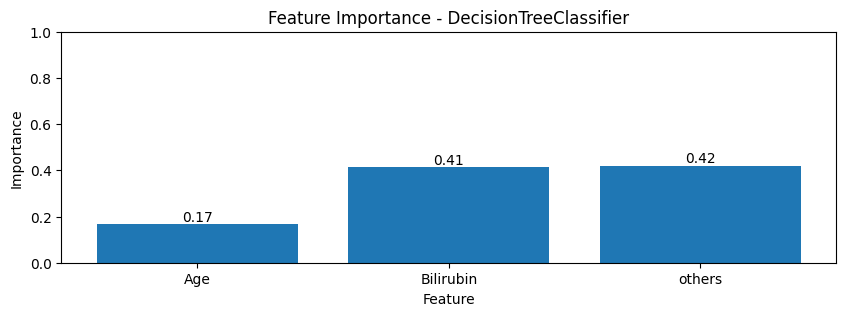

In [898]:
plot_importance_features(dtc)

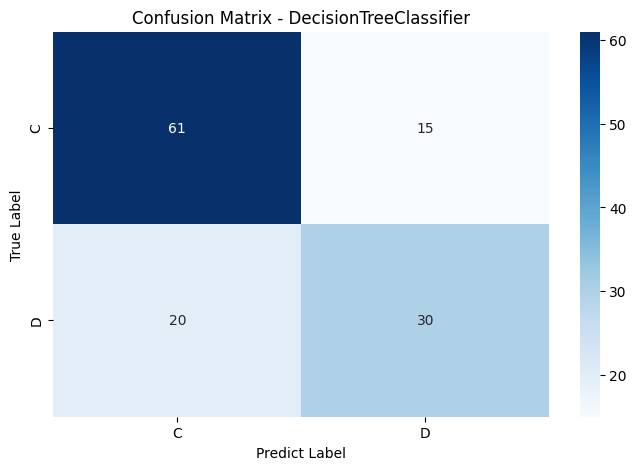

In [899]:
plot_confusion_matrix(dtc,y_test,predictions_1)

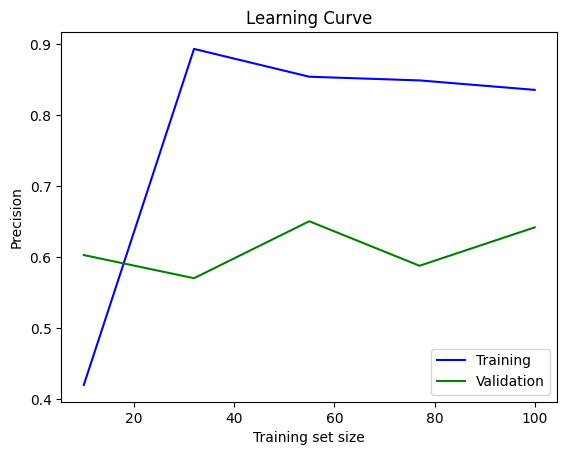

In [900]:
plot_learning_curve(dtc,y_test)

## `Decision Tree Classificator with Bagging`

In [901]:
dtcb = BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',max_depth=16),n_estimators=100)

dtcb.fit(x_train, y_train)
predictions_2 = dtcb.predict(x_test)
save_metrics(dtcb, y_test, predictions_2)

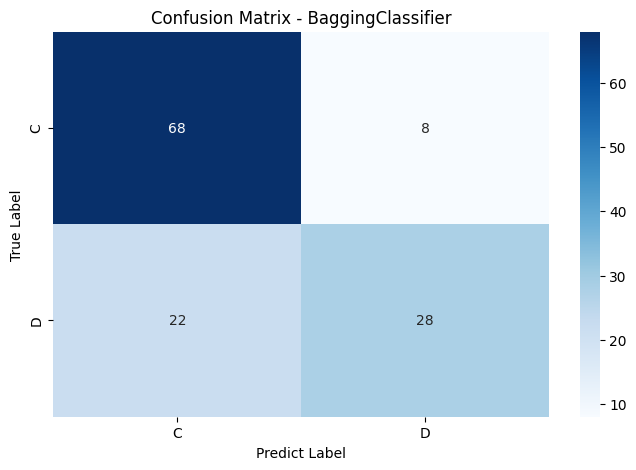

In [902]:
plot_confusion_matrix(dtcb,y_test,predictions_2)

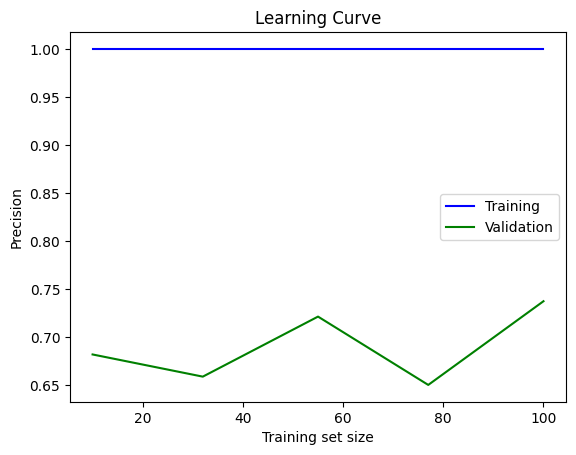

In [903]:
plot_learning_curve(dtcb,y_test)

## `AdaBoost Classifier`

In [904]:
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',min_samples_split=16,class_weight='balanced'),
                        n_estimators=100,
                        learning_rate=0.15,
                        algorithm='SAMME',
                        )

ada.fit(x_train, y_train)
predictions_3 = ada.predict(x_test)
save_metrics(ada, y_test, predictions_3)

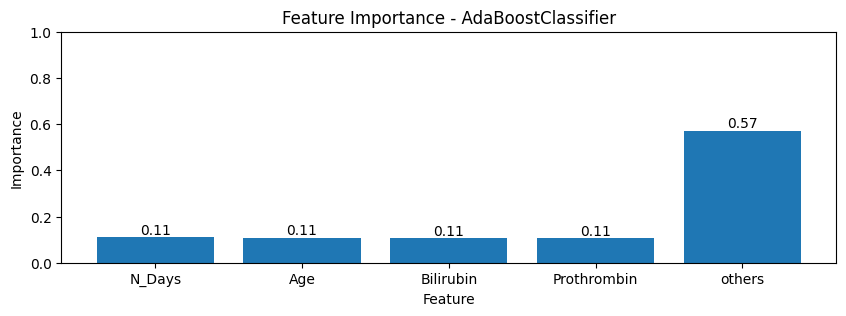

In [905]:
plot_importance_features(ada)

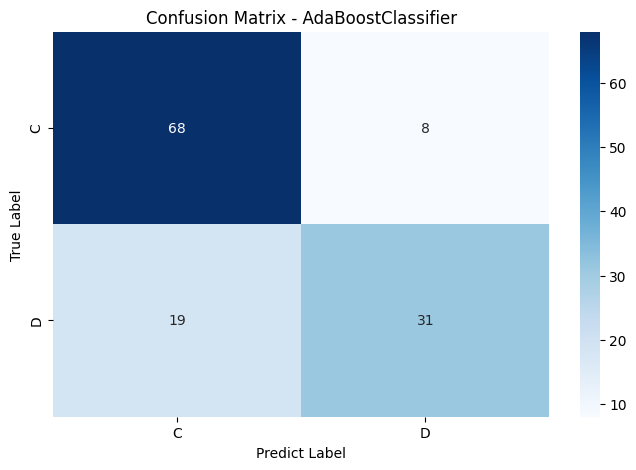

In [906]:
plot_confusion_matrix(ada,y_test,predictions_3)

g:\Machine-Learning\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "g:\Machine-Learning\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "g:\Machine-Learning\.venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "g:\Machine-Learning\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 169, in fit
    sample

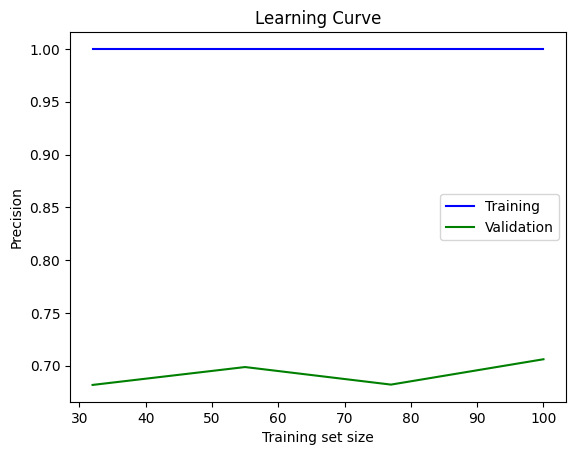

In [923]:
plot_learning_curve(ada,y_test)

## `Random Forest`

In [908]:
rf = RandomForestClassifier(criterion='gini',
                            min_samples_split=24,
                            class_weight='balanced')
rf.fit(x_train, y_train)
predictions_4 = rf.predict(x_test)
save_metrics(rf, y_test, predictions_4)

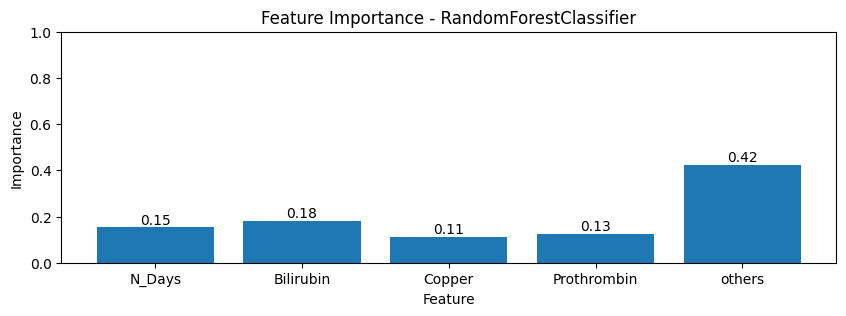

In [909]:
plot_importance_features(rf)

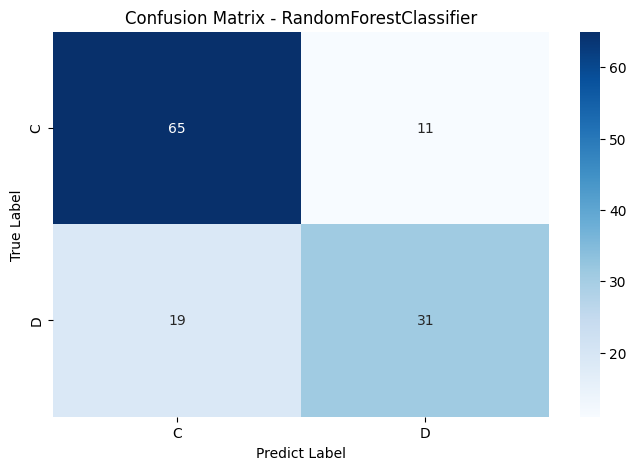

In [910]:
plot_confusion_matrix(rf,y_test,predictions_4)

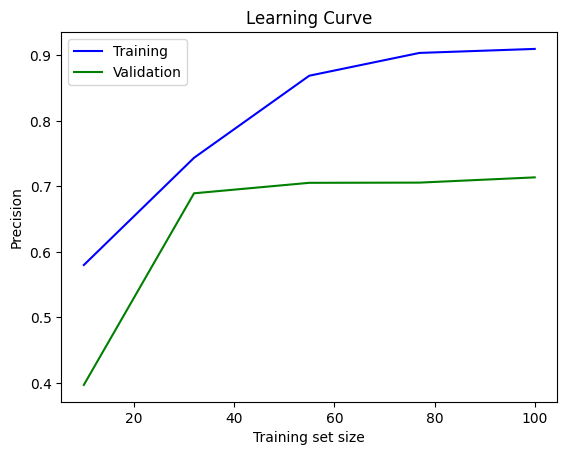

In [911]:
plot_learning_curve(rf,y_test)

## `XGBoost`

In [912]:
xgb_classifier = xgb.XGBClassifier(booster='gbtree',
                                    objective='binary:logistic',
                                    eval_metric='logloss',
                                    n_estimators=200,
                                    learning_rate = 0.1,max_depth=16)
xgb_classifier.fit(x_train, y_train)
predictions_5 = rf.predict(x_test)
save_metrics(xgb_classifier, y_test, predictions_5)

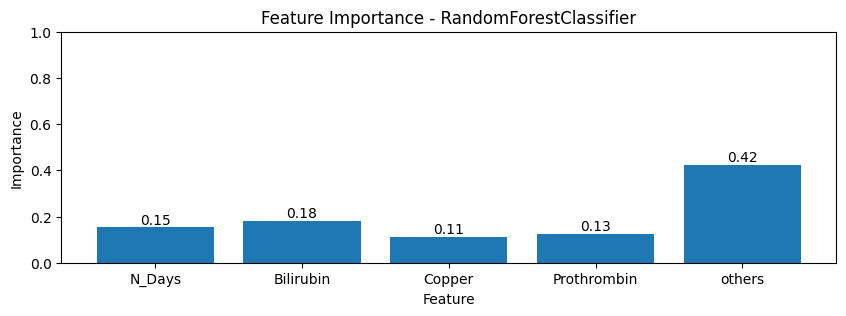

In [913]:
plot_importance_features(rf)

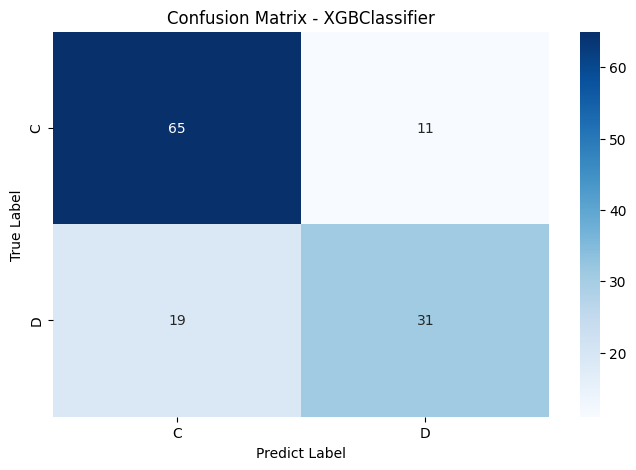

In [914]:
plot_confusion_matrix(xgb_classifier,y_test,predictions_5)

## `CatBoost`

In [915]:
cat = CatBoost.CatBoostClassifier(iterations=25, learning_rate=0.15, max_depth=16,min_data_in_leaf=24)

cat.fit(x_train, y_train)
predictions_6 = cat.predict(x_test)
save_metrics(cat, y_test, predictions_6)

0:	learn: 0.6767666	total: 1.88s	remaining: 45.2s
1:	learn: 0.6631359	total: 3.82s	remaining: 43.9s
2:	learn: 0.6491947	total: 5.82s	remaining: 42.7s
3:	learn: 0.6358364	total: 8.04s	remaining: 42.2s
4:	learn: 0.6225374	total: 10.3s	remaining: 41.1s
5:	learn: 0.6076161	total: 11.3s	remaining: 35.9s
6:	learn: 0.5743601	total: 11.3s	remaining: 29.1s
7:	learn: 0.5624499	total: 12.6s	remaining: 26.7s
8:	learn: 0.5521663	total: 14.6s	remaining: 25.9s
9:	learn: 0.5423536	total: 16.7s	remaining: 25.1s
10:	learn: 0.5326442	total: 18.7s	remaining: 23.8s
11:	learn: 0.5208216	total: 20.8s	remaining: 22.5s
12:	learn: 0.5119054	total: 22.9s	remaining: 21.1s
13:	learn: 0.5033092	total: 24.8s	remaining: 19.5s
14:	learn: 0.4860750	total: 24.8s	remaining: 16.5s
15:	learn: 0.4769490	total: 25.3s	remaining: 14.2s
16:	learn: 0.4659413	total: 27.3s	remaining: 12.8s
17:	learn: 0.4574763	total: 29.4s	remaining: 11.5s
18:	learn: 0.4499840	total: 31.5s	remaining: 9.94s
19:	learn: 0.4422222	total: 33.5s	remaini

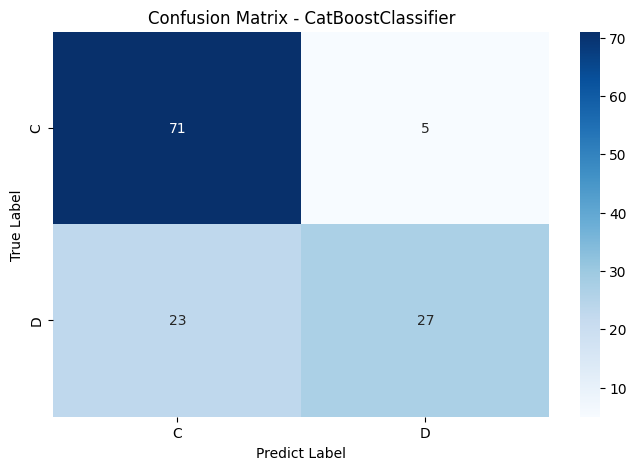

In [916]:
plot_confusion_matrix(cat, y_test, predictions_6)

## `Gradient Boosting Classifier`

In [936]:
gbc = GradientBoostingClassifier(loss='log_loss',
                                learning_rate=0.1,
                                n_estimators=150,
                                criterion='friedman_mse',
                                max_depth=16,
                                min_samples_split=24)

gbc.fit(x_train, y_train)
predictions_7 = gbc.predict(x_test)
save_metrics(gbc, y_test, predictions_7)

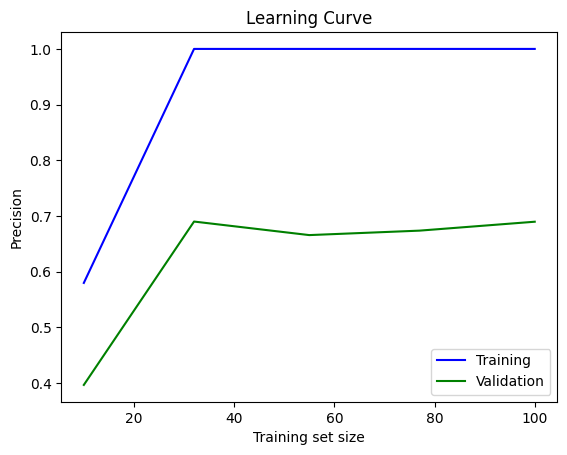

In [934]:
plot_learning_curve(gbc,y_test)

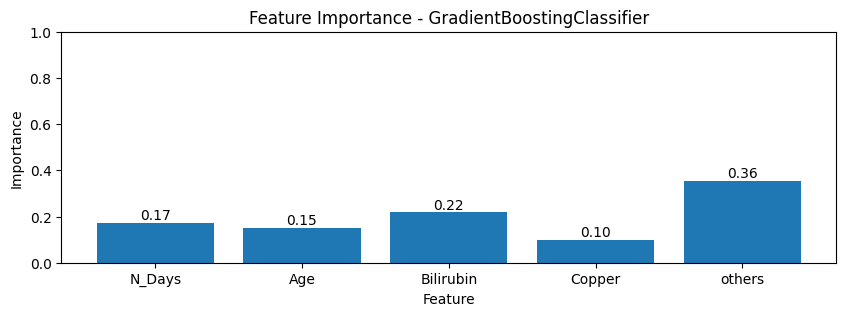

In [918]:
plot_importance_features(gbc)

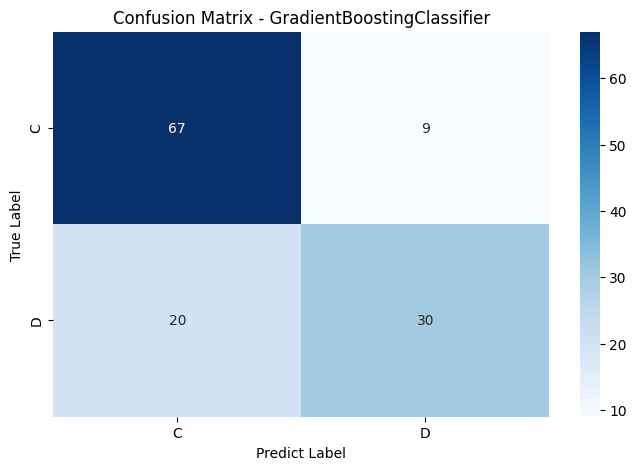

In [937]:
plot_confusion_matrix(gbc,y_test,predictions_7)

# 6. Model Evaluation

Based on the results, the **``GradientBoostingClassifier``** achieved the highest ``accuracy (0.81)`` and ``precision (0.81)`` among the models evaluated. However, its ``F1 score (0.739)`` and ``recall (0.68)`` indicate a trade-off between precision and recall, suggesting room for improvement in capturing true positive instances. The **``AdaBoostClassifier``** follows closely, with slightly lower performance metrics across the board but a higher precision (0.795) than the **``GradientBoostingClassifier``**. Meanwhile, the **``CatBoostClassifier``**, although having a lower ``accuracy (0.778)``, exhibited the highest ``precision (0.844)``, indicating that when it predicts a positive outcome, it is often correct, albeit with a lower ``recall (0.54)``, meaning it misses a significant number of actual positives. 

The **``BaggingClassifier``**, **``RandomForestClassifier``**, and **``XGBClassifier``** all presented similar performance levels, with accuracy around 0.762. The **``DecisionTreeClassifier``** showed the lowest ``accuracy (0.722)`` and ``precision (0.667)``, indicating it is less effective for this dataset.

The learning curves in `RandomForestClassifier` reveal that the training curve is higher than the validation curve, which suggests that the model may be overfitting. This means that while the model performs well on the training data, it does not generalize as effectively to unseen data. This highlights the need for strategies to improve generalization, such as adjusting hyperparameters, using more data, or implementing regularization techniques. Overall, the GradientBoostingClassifier stands out as the best-performing model, but attention should be given to enhancing its recall to improve overall model performance.

In [938]:
df_model = pd.DataFrame(list_metrics, columns=['model','accuracy','precision','f1','recall'])

In [942]:
df_model.sort_values(by=['accuracy'], ascending=False)

,model,accuracy,precision,f1,recall
6,GradientBoostingClassifier,0.809524,0.809524,0.739130,0.68
2,AdaBoostClassifier,0.785714,0.794872,0.696629,0.62
5,CatBoostClassifier,0.777778,0.843750,0.658537,0.54
1,BaggingClassifier,0.761905,0.777778,0.651163,0.56
3,RandomForestClassifier,0.761905,0.738095,0.673913,0.62
4,XGBClassifier,0.761905,0.738095,0.673913,0.62
0,DecisionTreeClassifier,0.722222,0.666667,0.631579,0.60
